In [4]:
!pip install --user sparse

     |████████████████████████████████| 81kB 22.9MB/s eta 0:00:01


In [1]:
pip install --user graphviz

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np

import dask
import dask.array as da
from scipy import sparse as scsparse
import sparse

import matplotlib.pyplot as plt
from oceanoi import cov, oisparse, oi

In [2]:
from distributed import Client

In [3]:
Client?

In [2]:
@dask.delayed(pure=True)
def cov_on_chunked_1d_dask(x1, x2, covfunc, covparams, threshold):
    K = covfunc(x1[:,None], x2[:,None].T, covparams)
    idx = np.abs(K)>threshold
    R,C = np.where(idx)
    
    return scsparse.csc_matrix((K[idx], (R,C)), 
                shape=K.shape)


def create_cov_chunked_dask(x1, x2, covfunc, covparams, threshold, chunksize, chunkedfunc):
    
    numrows = x1.shape[0]
    numcols = x2.shape[0]
    rows = []
    for r in range(0, numrows+chunksize, chunksize):
        cols = []
        for c in range(0, numcols+chunksize, chunksize):
            r1 = r + chunksize
            c1 = c + chunksize
            chunk1 = x1[r:r1,...]
            chunk2 = x2[c:c1,...]
            
            N,M = chunk1.shape[0], chunk2.shape[0]
            
            delayed_array = chunkedfunc(chunk1, chunk2, covfunc, covparams, threshold)
            
            cols.append(da.from_delayed(
                delayed_array,
                dtype='float',
                shape=(N,M),
            ))
            
        rows.append(da.hstack(cols))
        
    res = da.vstack(rows).compute()
    #res = sparse.triu(res, k=1)
    return res.tocsc()

    #return rows, cols, data

In [44]:
%%time
#########
# Parameters
noise = 0.1
covfunc = cov.expquad_1d
covparams = (1.15, 5.1)
dx = 0.8
N = 10000

#########


xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*2)

K_s = create_cov_chunked_dask(xd, xd, covfunc, covparams, 1e-12, 1000, cov_on_chunked_1d_dask)
K_s

CPU times: user 2.92 s, sys: 26.9 ms, total: 2.94 s
Wall time: 825 ms


<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 947744 stored elements in Compressed Sparse Column format>

In [45]:
%%time
K_s2 = oisparse.create_cov_chunked(xd, xd, covfunc, covparams, 1e-12, 1000, oisparse.cov_on_chunked_1d)
K_s2

CPU times: user 2.52 s, sys: 31.5 ms, total: 2.55 s
Wall time: 2.55 s


<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 947744 stored elements in Compressed Sparse Column format>

In [46]:
plt.figure()
plt.spy(K_s, ms=0.05)

In [50]:
def spectral_mixture_kernel(x, xpr, params):
    eta, l, T = params
    return eta**2 *cov.expquad(x, xpr, l)*cov.cosine(x, xpr, T)


In [51]:
%%time
#########
# Parameters
noise = 0.1
covfunc = spectral_mixture_kernel
covparams = (1.15, 50.1, 5.1)
dx = 0.8
N = 10000

#########


xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*2)

K_s = create_cov_chunked_dask(xd, xd, covfunc, covparams, 1e-12, 1000, cov_on_chunked_1d_dask)
K_s

CPU times: user 5.24 s, sys: 385 ms, total: 5.62 s
Wall time: 1.88 s


<10000x10000 sparse matrix of type '<class 'numpy.float64'>'
	with 9055118 stored elements in Compressed Sparse Column format>

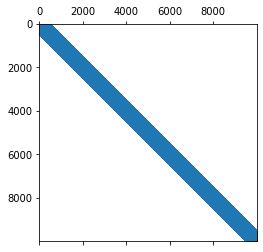

In [52]:
plt.figure()
plt.spy(K_s, ms=0.05)

In [2]:
from dask import array as da

In [4]:
%%time
#########
# Parameters
noise = 0.1
covfunc = cov.expquad_1d
covparams = (1.15, 5.1)
dx = 0.8
N = 25000

chunksize=5000
#########


xd = np.arange(0,dx*N,dx)[:,None]
xo = np.linspace(-10*dx,dx*N+dx*10,N*2)[:,None]

xd_d = da.from_array(xd, chunks=(chunksize,1))
xo_d = da.from_array(xo, chunks=(chunksize,1))

sigI = da.eye(N,chunks=chunksize)*(noise+1e-7)

K_d = covfunc(xd_d, xd_d.T, covparams)

K_d += sigI
K_d

CPU times: user 4.4 ms, sys: 8.17 ms, total: 12.6 ms
Wall time: 11.7 ms


dask.array<add, shape=(25000, 25000), dtype=float64, chunksize=(5000, 5000), chunktype=numpy.ndarray>

In [15]:
%%time
L = da.linalg.cholesky(K_d, lower=True).persist()

CPU times: user 2min 40s, sys: 58.4 s, total: 3min 38s
Wall time: 56.6 s


In [16]:
#L.visualize()

In [17]:
%%time 
#L.compute()
myrand = da.random.random((N,1))

yd = L.dot(myrand)

#yd = yd.compute()

CPU times: user 3.84 ms, sys: 0 ns, total: 3.84 ms
Wall time: 3.57 ms


In [10]:
%%time
v = da.linalg.solve_triangular(L, yd, lower=True)
alpha = da.linalg.solve_triangular(L.T, v, lower=False)

alpha.compute()

CPU times: user 2.08 s, sys: 1.59 s, total: 3.67 s
Wall time: 932 ms


array([[1.80561267e-04],
       [2.56783773e-05],
       [1.21048122e-04],
       ...,
       [2.75466640e-04],
       [1.50109824e-04],
       [1.04672563e-06]])

In [9]:
da.diagonal(L)

dask.array<diagonal, shape=(25000,), dtype=float64, chunksize=(5000,), chunktype=numpy.ndarray>

In [18]:
#%%time
#v2 = da.linalg.solve(K_d, yd).compute()

In [19]:
# Try converting to a sparse matrix
K_d[K_d<1e-8] = 0

K_d_s = K_d.map_blocks(sparse.COO)

K_d_s

dask.array<COO, shape=(25000, 25000), dtype=float64, chunksize=(5000, 5000), chunktype=sparse.COO>

In [11]:
%%time
LU = da.linalg.lu(K_d_s)

CPU times: user 1.21 ms, sys: 0 ns, total: 1.21 ms
Wall time: 1.22 ms


In [12]:
LU

(dask.array<lu-p, shape=(25000, 25000), dtype=float64, chunksize=(5000, 5000), chunktype=sparse.COO>,
 dask.array<lu-l, shape=(25000, 25000), dtype=float64, chunksize=(5000, 5000), chunktype=sparse.COO>,
 dask.array<lu-u, shape=(25000, 25000), dtype=float64, chunksize=(5000, 5000), chunktype=sparse.COO>)

In [42]:
class OptimalInterpDask(object):
    """
    Optimal interpolation in one dimension (usually time)
    
    """
    
    chunksize=1000
    threshold=1e-15
    #chunkedcovfunc = cov_on_chunked_1d
    
    def __init__(self, xd, xm, sd, cov_func, cov_params, **kwargs):
        
        self.__dict__.update(kwargs)
        
        assert xd.ndim==2
        
        self.N, self.D = xd.shape
        self.M, D = xm.shape

        self.xd = da.from_array(xd, chunks=(self.chunksize,1))
        self.xm = da.from_array(xm, chunks=(self.chunksize,1))
        
        self.sd = sd
        self.cov_func = cov_func
        self.cov_params = cov_params
        
        self.Kmd, self.Kdd = self._calc_cov(cov_func, cov_params)
        
        self.L, self.w_md = self._calc_weights(self.Kdd, self.sd, self.Kmd)
        
    def __call__(self, yd):
        
        assert yd.shape[0] == self.N, ' first dimension in input data must equal '
        
        yd = da.from_array(yd, chunks=(self.chunksize,1))

        v = da.linalg.solve_triangular(self.L, yd, lower=True)
        alpha = da.linalg.solve_triangular(self.L.T, v, lower=False)
        
        return self.Kmd.dot(alpha)
        
    
    def _calc_cov(self, cov_func, cov_params):
        # Compute the covariance functions
        Kmd = cov_func(self.xm[:,...], self.xd[:,...].T, cov_params)
        Kdd = cov_func(self.xd[:,...], self.xd[:,...].T, cov_params)
        return Kmd, Kdd
    
    def _calc_weights(self, Kdd, sd, Kmd):
        
        # Calculate the cholesky factorization
        w_md = None
        
        sigI = da.eye(self.N,chunks=self.chunksize)*(sd+1e-7)
        
        L = da.linalg.cholesky(Kdd+sigI, lower=True).persist()

        return L, w_md

    def calc_err(self, diag=True):

        Kmm = self.cov_func(self.xm[:,...], self.xm[:,...].T, self.cov_params)
        Kdm = self.cov_func(self.xd[:,...], self.xm[:,...].T, self.cov_params)
        
        V = Kmm - self.w_md.T.dot(Kdm)

        if diag:
            return V.diagonal()
        else:
            return V
        
    def sample_posterior(self, yd, samples):
        
        print('Warning this sampling may blowout your memory!!')
        # Predict the mean
        ymu = self.__call__(yd)

        # Predict the covariance
        Σ = self.calc_err(diag=False)

        return np.random.multivariate_normal(ymu.ravel(), Σ, samples)
    
    def sample_prior(self, samples):
        
        myrand = da.random.normal(size=(self.N,samples)) 
        return self.L.dot(myrand)

    
    def log_marg_likelihood(self, yd):
        
        yd = da.from_array(yd, chunks=(self.chunksize,1))
        
        logdet = 2*da.sum(da.log(da.diagonal(self.L)))
        
        v = da.linalg.solve_triangular(self.L, yd, lower=True)
        alpha = da.linalg.solve_triangular(self.L.T, v, lower=False)
        
        qdist = da.dot(yd.T, alpha)[0,0]
        
        fac = self.N * da.log(2*np.pi)
        
        return -0.5*(logdet + qdist + fac)
      
            

In [43]:
%%time

np.random.seed(1) # this generates the same output every time
# Generate some training data

#########
# Parameters
noise = 0.1
covfunc = cov.expquad_1d
covparams = (1.15, 2.1)
dx = 0.8
N = 2000

chunksize=1000

#########


xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*2)

OIs = OptimalInterpDask(xd[:,None], xo[:,None], noise, covfunc, covparams, chunksize=chunksize, threshold=1e-21)

yd_d = OIs.sample_prior(1).compute()
yo_d = OIs(yd_d)
# yd_d = yd_d.compute()

CPU times: user 243 ms, sys: 137 ms, total: 380 ms
Wall time: 115 ms


In [44]:
%%time

np.random.seed(1) # this generates the same output every time
# Generate some training data

#########
# Parameters
noise = 0.1
covfunc = cov.expquad_1d
covparams = (1.15, 2.1)
dx = 0.8
N = 2000

chunksize=2000

#########


xd = np.arange(0,dx*N,dx)
xo = np.linspace(-10*dx,dx*N+dx*10,N*2)

OI = oi.OptimalInterp1D(xd, xo, noise, covfunc, covparams)

yd = OI.sample_prior(1)
yo = OI(yd[...].T)


CPU times: user 6.71 s, sys: 2.3 s, total: 9.01 s
Wall time: 2.54 s


In [48]:
OI.log_marg_likelihood(yd_d), OIs.log_marg_likelihood(yd_d).compute()

(-5443.4054317469545, -2245.2072188027437)

In [47]:
plt.figure()
plt.plot(xo, yo, lw=0.2)
plt.plot(xo, yo_d, lw=0.2)

In [57]:
yd_d = OIs.sample_prior(1)
v = da.linalg.solve_triangular(OIs.L, yd_d, lower=True)
alpha = da.linalg.solve_triangular(OIs.L.T, v, lower=False)
        
qdist = da.dot(yd_d.T, alpha)[0,0]
qdist.compute()

2023.5574471078967